<a href="https://colab.research.google.com/github/igorgad/covid-ts-it/blob/master/BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoVID19 Time Series Modeling - BiLSTM

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv
!wget https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json
!wget https://covid.saude.gov.br/assets/files/COVID19_20200402.csv

--2020-04-20 03:00:12--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75003 (73K) [text/plain]
Saving to: ‘time_series_covid19_confirmed_global.csv’

time_series_covid19 100%[===================>]  73.25K  --.-KB/s    in 0.02s   

2020-04-20 03:00:12 (2.91 MB/s) - ‘time_series_covid19_confirmed_global.csv’ saved [75003/75003]

--2020-04-20 03:00:16--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ..

# Loading Data


In [ ]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')
# Replace unkown province/state with the country name
df['Province/State'] = df['Country/Region'] + '-' + df['Province/State']
df.fillna({'Province/State': df['Country/Region']}, inplace=True)
sdf = df.iloc[:, 4:].T.astype(np.float32)
sdf.columns = df['Province/State']
sdf.index = pd.DatetimeIndex(sdf.index)
sdf.head()

Province/State,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia-Australian Capital Territory,Australia-New South Wales,Australia-Northern Territory,Australia-Queensland,Australia-South Australia,Australia-Tasmania,Australia-Victoria,Australia-Western Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cabo Verde,Cambodia,Cameroon,Canada-Alberta,Canada-British Columbia,Canada-Grand Princess,Canada-Manitoba,Canada-New Brunswick,...,Uruguay,US,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe,Canada-Diamond Princess,Dominica,Grenada,Mozambique,Syria,Timor-Leste,Belize,Canada-Recovered,Laos,Libya,West Bank and Gaza,Guinea-Bissau,Mali,Saint Kitts and Nevis,Canada-Northwest Territories,Canada-Yukon,Kosovo,Burma,United Kingdom-Anguilla,United Kingdom-British Virgin Islands,United Kingdom-Turks and Caicos Islands,MS Zaandam,Botswana,Burundi,Sierra Leone,"Netherlands-Bonaire, Sint Eustatius and Saba",Malawi,United Kingdom-Falkland Islands (Malvinas),France-Saint Pierre and Miquelon,South Sudan,Western Sahara,Sao Tome and Principe,Yemen
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fixing WHO Hubei data according to the paper

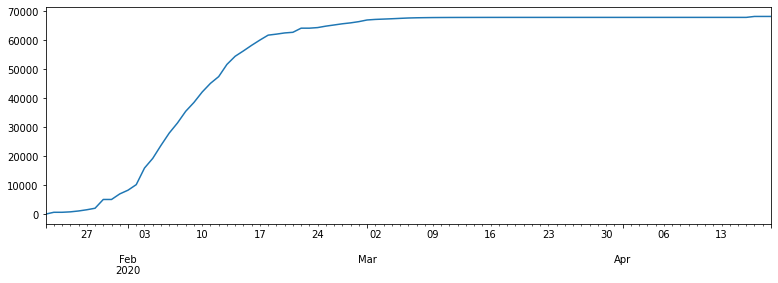

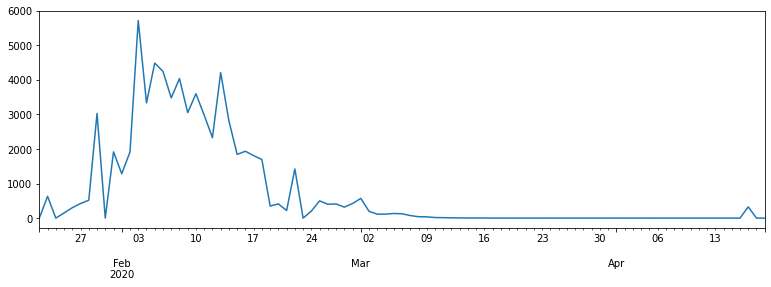

In [ ]:
def fix_hubei_data(sub_data):
    index = np.where(sub_data.index == '2020-02-12')[0][0] + 1
    # Shift data one day to the future
    sub_data.iloc[:index] = np.concatenate([np.zeros([1,]), sub_data.iloc[:index-1].values])

    # Apply parameter to normalize lab tested cases and clinical + lab tested cases
    sub_data.iloc[:index] = sub_data.iloc[:index] * (1 + 15384 / 36602)
    sub_data.iloc[index] = sub_data.iloc[index] * (0.65 + 15384 / 36602)

    return sub_data

# Fix Hubei data
if 'China-Hubei' in sdf.columns:
    sdf['China-Hubei'] = fix_hubei_data(sdf['China-Hubei'])

sdf['China-Hubei'].plot(figsize=(13, 4))
plt.figure()
sdf['China-Hubei'].diff().fillna(0).plot(figsize=(13, 4))

## Normalize by day of first case

In [ ]:
# Normalize data by the day of the first case
date_index = pd.DatetimeIndex(sdf.index)
day_of_first_case = sdf.ne(0).idxmax()
shifts = []
for region in sdf.columns:
    shift_index = np.where(sdf.index == day_of_first_case[region])[0][0]
    sdf[region] = sdf[region].shift(-1 * shift_index, fill_value=np.nan) #sdf[region][-1])
    shifts.append(shift_index)

sdf.index = np.arange(len(sdf.index))
shifts_df = pd.DataFrame(np.expand_dims(np.array(shifts), 0), columns=sdf.columns)
day_of_first_case

Province/State
Afghanistan                        2020-02-24
Albania                            2020-03-09
Algeria                            2020-02-25
Andorra                            2020-03-02
Angola                             2020-03-20
                                      ...    
France-Saint Pierre and Miquelon   2020-04-05
South Sudan                        2020-04-05
Western Sahara                     2020-04-05
Sao Tome and Principe              2020-04-06
Yemen                              2020-04-10
Length: 264, dtype: datetime64[ns]

## Plot some data

In [ ]:
all_regions = sdf.columns
print ('List of available countries or regions: ' + str(all_regions))
sdf

List of available countries or regions: Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia-Australian Capital Territory', 'Australia-New South Wales',
       ...
       'Burundi', 'Sierra Leone',
       'Netherlands-Bonaire, Sint Eustatius and Saba', 'Malawi',
       'United Kingdom-Falkland Islands (Malvinas)',
       'France-Saint Pierre and Miquelon', 'South Sudan', 'Western Sahara',
       'Sao Tome and Principe', 'Yemen'],
      dtype='object', name='Province/State', length=264)


Province/State,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia-Australian Capital Territory,Australia-New South Wales,Australia-Northern Territory,Australia-Queensland,Australia-South Australia,Australia-Tasmania,Australia-Victoria,Australia-Western Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cabo Verde,Cambodia,Cameroon,Canada-Alberta,Canada-British Columbia,Canada-Grand Princess,Canada-Manitoba,Canada-New Brunswick,...,Uruguay,US,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe,Canada-Diamond Princess,Dominica,Grenada,Mozambique,Syria,Timor-Leste,Belize,Canada-Recovered,Laos,Libya,West Bank and Gaza,Guinea-Bissau,Mali,Saint Kitts and Nevis,Canada-Northwest Territories,Canada-Yukon,Kosovo,Burma,United Kingdom-Anguilla,United Kingdom-British Virgin Islands,United Kingdom-Turks and Caicos Islands,MS Zaandam,Botswana,Burundi,Sierra Leone,"Netherlands-Bonaire, Sint Eustatius and Saba",Malawi,United Kingdom-Falkland Islands (Malvinas),France-Saint Pierre and Miquelon,South Sudan,Western Sahara,Sao Tome and Principe,Yemen
0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,1.0,...,4.0,1.0,1.0,2.0,2.0,2.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,4.0,2.0,2.0,2.0,1.0,3.0,71.0,8.0,2.0,2.0,4.0,2.0,3.0,2.0,1.0,2.0,3.0,1.0,1.0,1.0,4.0,4.0,1.0
1,1.0,10.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,4.0,1.0,3.0,2.0,1.0,1.0,2.0,2.0,3.0,1.0,23.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,4.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0,4.0,1.0,...,4.0,1.0,6.0,10.0,2.0,2.0,3.0,-1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,7.0,2.0,4.0,2.0,1.0,3.0,86.0,8.0,2.0,2.0,4.0,2.0,4.0,2.0,2.0,2.0,3.0,2.0,1.0,1.0,4.0,4.0,1.0
2,1.0,12.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,4.0,0.0,2.0,2.0,1.0,1.0,2.0,3.0,3.0,1.0,33.0,3.0,5.0,1.0,1.0,2.0,1.0,3.0,3.0,1.0,11.0,4.0,2.0,3.0,1.0,2.0,4.0,1.0,2.0,4.0,1.0,...,8.0,2.0,10.0,17.0,2.0,2.0,3.0,-1.0,2.0,1.0,3.0,1.0,1.0,2.0,0.0,6.0,1.0,16.0,2.0,11.0,2.0,1.0,4.0,91.0,10.0,2.0,2.0,5.0,2.0,4.0,3.0,2.0,2.0,4.0,2.0,1.0,2.0,4.0,4.0,1.0
3,1.0,23.0,1.0,1.0,3.0,1.0,2.0,1.0,2.0,4.0,0.0,3.0,2.0,1.0,1.0,2.0,3.0,3.0,3.0,33.0,3.0,5.0,1.0,1.0,2.0,1.0,10.0,3.0,2.0,11.0,7.0,2.0,3.0,1.0,2.0,7.0,1.0,2.0,7.0,1.0,...,29.0,2.0,15.0,33.0,2.0,2.0,3.0,-1.0,7.0,1.0,5.0,5.0,1.0,2.0,0.0,6.0,1.0,16.0,2.0,18.0,2.0,1.0,4.0,94.0,14.0,2.0,3.0,5.0,2.0,4.0,3.0,2.0,2.0,4.0,2.0,1.0,2.0,4.0,4.0,1.0
4,1.0,33.0,1.0,1.0,3.0,1.0,8.0,1.0,2.0,4.0,0.0,2.0,2.0,1.0,2.0,2.0,9.0,6.0,3.0,36.0,3.0,6.0,1.0,1.0,2.0,1.0,10.0,3.0,2.0,37.0,7.0,2.0,3.0,1.0,2.0,7.0,1.0,8.0,8.0,2.0,...,50.0,5.0,23.0,36.0,2.0,3.0,3.0,-1.0,11.0,7.0,7.0,5.0,1.0,2.0,0.0,8.0,3.0,19.0,2.0,18.0,2.0,1.0,4.0,94.0,15.0,2.0,3.0,6.0,9.0,4.0,3.0,4.0,2.0,5.0,5.0,1.0,3.0,4.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2926.0,NaN,NaN,NaN,NaN,1319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,636350.0,NaN,NaN,268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,667592.0,NaN,NaN,268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Total number of places (Province/State/Country/Region): 4


Province/State
China-Hubei   2020-01-23
Italy         2020-01-31
Brazil        2020-02-26
dtype: datetime64[ns]

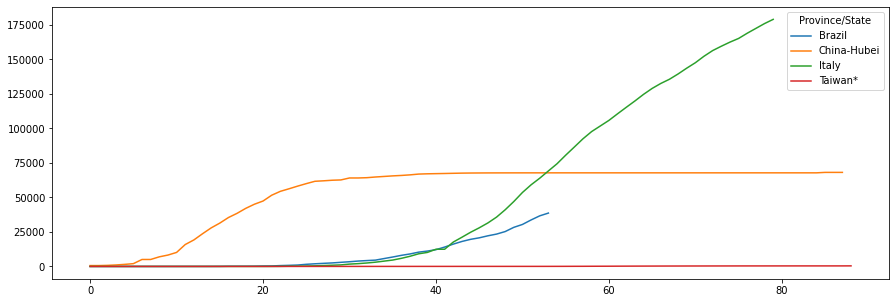

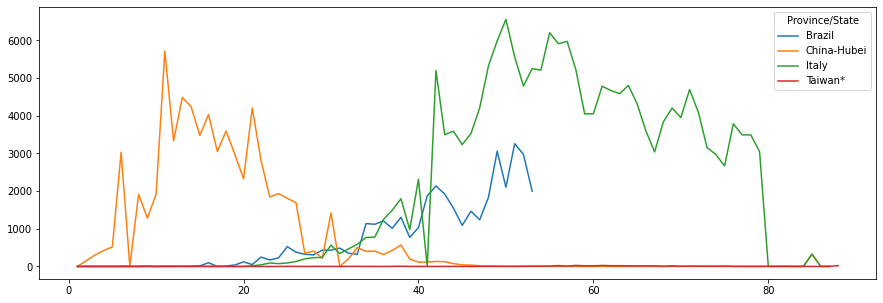

In [ ]:
# Select which countries/regions to use on the dataset
selected_regions = ['China-Hubei', 'Taiwan*', 'Italy', 'Brazil']
rdf = sdf.loc[:, sdf.columns.str.contains(r'|'.join(selected_regions))]

print('Total number of places (Province/State/Country/Region): ' + str(len(rdf.columns)))
rdf.plot(figsize=(15, 5))
rdf.diff().fillna(axis=1, method='ffill').plot(figsize=(15, 5))
day_of_first_case.loc[['China-Hubei', 'Italy', 'Brazil']]

## Data Preprocessing

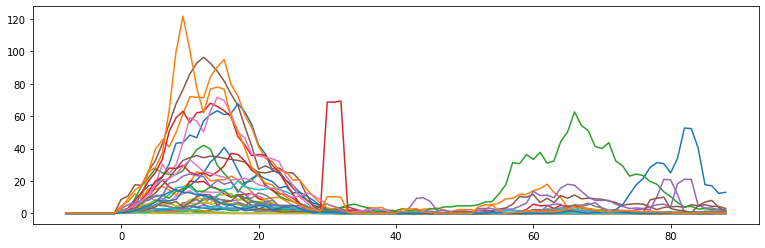

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def get_data(df, regions=['China'], pad_start=None, pad_end=None, normalize=None, average_size=1):
    # Select which countries/regions to use on the dataset
    if regions:
        data = df.loc[:, df.columns.str.contains(r'|'.join(regions))]
    else:
        data = df

    if pad_start:
        # Pad the Begging and End of data
        beg_index = -1 * np.arange(pad_start, 0, -1)
        beg_zero_df = pd.DataFrame(np.zeros([len(beg_index), len(data.columns)]),
                        columns=data.columns,
                        index=beg_index)
        data = pd.concat([beg_zero_df, data], axis=0)
        
    if pad_end:
        end_index = np.arange(data.index[-1], data.index[-1] + pad_end)
        end_zero_df = pd.DataFrame(np.nan * np.ones([len(end_index), len(data.columns)]),
                        columns=data.columns,
                        index=end_index)
        
        data = pd.concat([data, end_zero_df], axis=0)

    # Differentiate to obtain daily cases
    # data = data.diff(axis=0).astype(np.float32)
    # data = data.diff(axis=0).fillna(0.0).astype(np.float32)
    data = data.diff(axis=0).fillna(data).astype(np.float32)
    # data = data.diff(axis=0).fillna(data).astype(np.float32)

    # Moving Average
    data = data.rolling(average_size, min_periods=1).mean() #.fillna(data)
    
    # Normalizing
    scaler = None
    if normalize == 'MinMax':
        scaler = MinMaxScaler()
        data[data.columns] = scaler.fit_transform(data[data.columns])
    if normalize == 'Standard':
        scaler = StandardScaler()
        data[data.columns] = scaler.fit_transform(data[data.columns])

    return data, scaler

data, _ = get_data(sdf, regions=['China'], pad_start=8, normalize=None, average_size=3)
data.loc[:, data.columns != 'China-Hubei'].fillna(0.0).plot(figsize=(13, 4), legend=False)

# LSTM Time Series

## Sequences Generation

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

class MAEtsGenerator(TimeseriesGenerator):
    def __init__(self, *args, **kwargs):
        self.norm = kwargs.pop('normalization')
        super(MAEtsGenerator, self).__init__(*args, **kwargs)

    def __getitem__(self, index):
        samples, targets = super().__getitem__(index)
        samples = np.reshape(np.transpose(samples, [0, 2, 1]), [-1, self.length])
        targets = np.reshape(np.expand_dims(targets, -1), [-1, 1])

        # Normalizing
        if self.norm == 'Standard':
            S = samples.std(axis=1, keepdims=True)
            M = samples.mean(axis=1, keepdims=True)
            samples = np.divide(samples - M, S, out=np.zeros_like(samples), where=S!=0)
            targets = np.divide(targets - M, S, out=np.zeros_like(targets), where=S!=0)

        if self.norm == 'DivMean':
            M = samples.mean(axis=1, keepdims=True)
            samples = np.divide(samples, M, out=np.zeros_like(samples), where=M!=0)
            targets = np.divide(targets, M, out=np.zeros_like(targets), where=M!=0)
        
        if self.norm == 'MinMax':
            max = samples.max(axis=1, keepdims=True)
            min = samples.min(axis=1, keepdims=True)
            minmaxdiff = max - min
            samples = np.divide(samples - min, minmaxdiff, out=np.zeros_like(samples), where=minmaxdiff!=0)
            targets = np.divide(targets - min, minmaxdiff, out=np.zeros_like(targets), where=minmaxdiff!=0)
        return samples, targets

[0.02439024 0.2195122  0.36585366 0.92682927 1.24390244 1.34146341
 1.63414634 2.24390244 3.17073171]


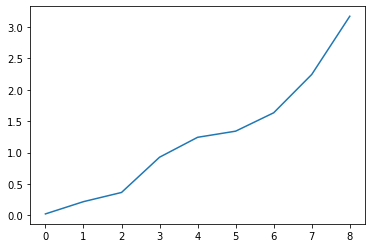

In [ ]:
def get_sequence_generator(data, normalization='divmean', length=8, shuffle=True, batch_size=1):
    generator = MAEtsGenerator(data.values, data.values, length=length, batch_size=batch_size, normalization=normalization, shuffle=shuffle)
    return generator

generator = get_sequence_generator(data, normalization='DivMean', shuffle=False)
train_exs = 0
for i, (x, y) in enumerate(generator):
    train_exs += 1

x, y = generator[8]
samples_n_targets = np.concatenate([x[0,:], y[0]])
plt.plot(samples_n_targets)
print(samples_n_targets)

## Training Loop

In [ ]:
# def train_loop(train_generator, validation_data, epochs, callbacks):
#     for epoch in range(epochs):

def train(models, train_generator, eval_generator, lr=1e-3, epochs=100):
    def train_model(model):
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=0),
            # tf.keras.callbacks.ModelCheckpoint(workspace + '/Checkpoints/MAE', monitor='val_loss', save_best_only=True, verbose=0)
        ]

        model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), 
                      loss='mean_squared_error')


        trace = model.fit(train_generator, epochs=epochs, validation_data=eval_generator, callbacks=callbacks, verbose=0)
        # tf.keras.backend.clear_session()
        return trace
    return [train_model(model) for model in models]

## Evaluation Loop

In [ ]:
def evaluate(models, generator, forecast_start_day=15, normalization='DivMean'):
    xi, yi = generator[0]

    predicted_values = np.zeros([xi.shape[0], 0])
    true_values = np.zeros([xi.shape[0], 0])

    # Iterate over a set with support data
    for i, (ex, y) in enumerate(generator):
        if i < forecast_start_day:
            x = ex
        # Normalize
        if normalization == 'Standard':
            S = x.std(axis=1, keepdims=True)
            M = x.mean(axis=1, keepdims=True)
            x = np.divide(x - M, S, out=np.zeros_like(x), where=S!=0)
        if normalization == 'DivMean':
            # M = np.concatenate([x, y], axis=1).mean(axis=1, keepdims=True)
            M = x.mean(axis=1, keepdims=True)
            x = np.divide(x, M, out=np.zeros_like(x), where=M!=0)
        if normalization == 'MinMax':
            max = x.max(axis=1, keepdims=True)
            min = x.min(axis=1, keepdims=True)
            minmaxdiff = max - min
            x = np.divide(x - min, minmaxdiff, out=np.zeros_like(x), where=minmaxdiff!=0)
        # Predict
        outs = [model.predict(x) for model in models]
        # Average models predictions
        pred = np.array([out for out in outs]).mean(0)
        # Restore
        if normalization == 'Standard':
            pred = pred * S + M
            x = x * S + M
        if normalization == 'DivMean':
            pred = pred * M
            x = x * M
        if normalization == 'MinMax':
            pred = pred * minmaxdiff + min
            x = x * minmaxdiff + min
        # Append
        predicted_values = np.concatenate([predicted_values, pred], axis=1)
        true_values = np.concatenate([true_values, y], axis=1)
        # Shift
        x = np.concatenate([x, pred], axis=1)[:, 1:]        

    return predicted_values.T, true_values.T

## LSTM MAE Model

In [ ]:
# Parameters
train_regions = ['China-Hubei'] #, 'Taiwan*']
eval_regions = ['Italy']
num_models = 1
data_normalization = 'MinMax' #None
block_normalization = None #'DivMean'
sequence_length = 14
lr = 1e-3
pad_start = sequence_length
average_size = 3

### Defining Model

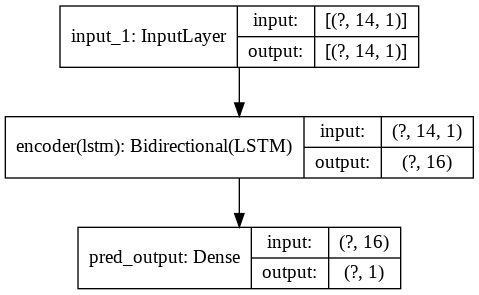

In [ ]:
tf.keras.backend.clear_session()
sd = 1
tf.random.set_seed(sd)
np.random.seed(sd)
def make_lstm_model(sequence_length=8, units=8):
    # MAE Model 
    lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, activation='relu', return_sequences=False, kernel_initializer='glorot_uniform'), name='encoder')
    # lstm_layer = tf.keras.layers.LSTM(units, activation='relu', return_sequences=False, kernel_initializer='glorot_uniform', name='encoder')
    in_m = tf.keras.Input(shape=(sequence_length, 1))
    lstm = lstm_layer(in_m)
    # lstm = tf.keras.layers.BatchNormalization()(lstm)
    # lstm = tf.keras.layers.Dropout(0.5)(lstm)
    pred = tf.keras.layers.Dense(1, activation='linear', name='pred_output', kernel_initializer='glorot_uniform')(lstm)
    
    model = tf.keras.Model(in_m, pred, name='mLSTM')
    return model

models = [make_lstm_model(sequence_length) for _ in range(num_models)]
from tensorflow.keras.utils import plot_model
plot_model(models[0], show_shapes=True, show_layer_names=True, to_file='model.png')

### Training

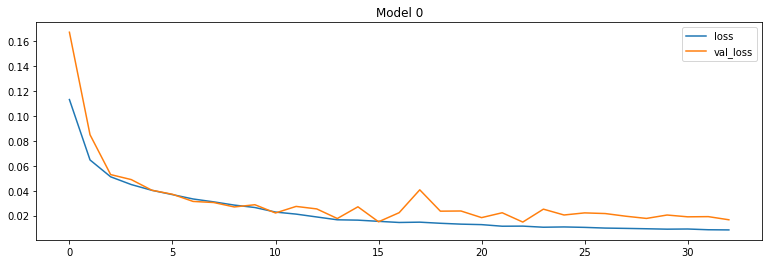

In [ ]:
train_data, _ = get_data(sdf, regions=train_regions, pad_start=pad_start, pad_end=None, normalize=data_normalization, average_size=average_size)
eval_data, _ = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=None, normalize=data_normalization, average_size=average_size)

train_generator = get_sequence_generator(train_data.fillna(0.0), length=sequence_length, normalization=block_normalization, shuffle=False, batch_size=1)
eval_generator = get_sequence_generator(eval_data.fillna(0.0), length=sequence_length, normalization=block_normalization, shuffle=False, batch_size=1)

traces = train(models, train_generator, eval_generator, lr=lr, epochs=100)

for i,trace in enumerate(traces):
    pd.DataFrame(np.stack([trace.history['loss'], 
                           trace.history['val_loss']], axis=1), 
                 columns={'loss', 'val_loss'}).plot(figsize=(13, 4), title='Model %d' % i)


### Forecasting

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.nanmean(np.divide(np.abs(y_true - y_pred), y_true, out=np.ones_like(y_true) * np.nan, where=y_true!=0), axis=0) * 100

#### China

                              MAPE      XCOR
Province/State                              
China-Anhui             487.831192  0.887699
China-Beijing           181.760619  0.828753
China-Chongqing         434.622145  0.829678
China-Fujian            219.932190  0.852051
China-Gansu             163.744908  0.520492
China-Guangdong         379.725645  0.741204
China-Guangxi           144.543902  0.894054
China-Guizhou           371.301825  0.841347
China-Hainan             49.560650  0.717573
China-Hebei             252.462292  0.817872
China-Heilongjiang      448.043813  0.494025
China-Henan            1561.269396  0.856596
China-Hong Kong         283.609043  0.121946
China-Hubei           45652.687149  0.806129
China-Hunan             654.787895  0.806167
China-Inner Mongolia    151.182461  0.044972
China-Jiangsu           456.794812  0.824882
China-Jiangxi          1036.108653  0.816895
China-Jilin             327.226490  0.476102
China-Liaoning          163.910558  0.842772
China-Maca

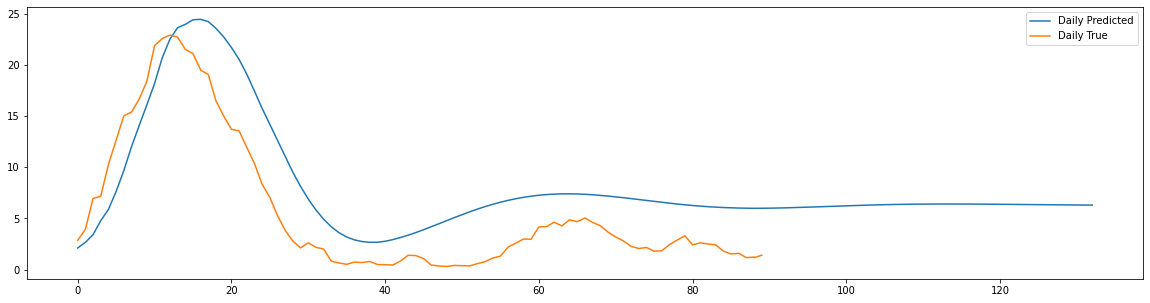

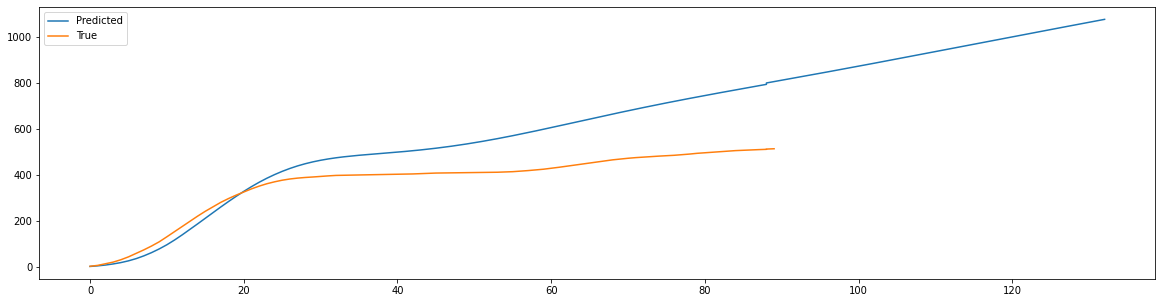

In [ ]:
eval_regions = ['China', 'Taiwan*']
forecast_start_day = 15
# average_size = 3
pad_start = sequence_length
pad_end = 45

eval_data, _ = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = evaluate(models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=eval_data.index[sequence_length:])
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=eval_data.index[sequence_length:])

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### Italy

MAPE    7660.230538
XCOR       0.961865
dtype: float64


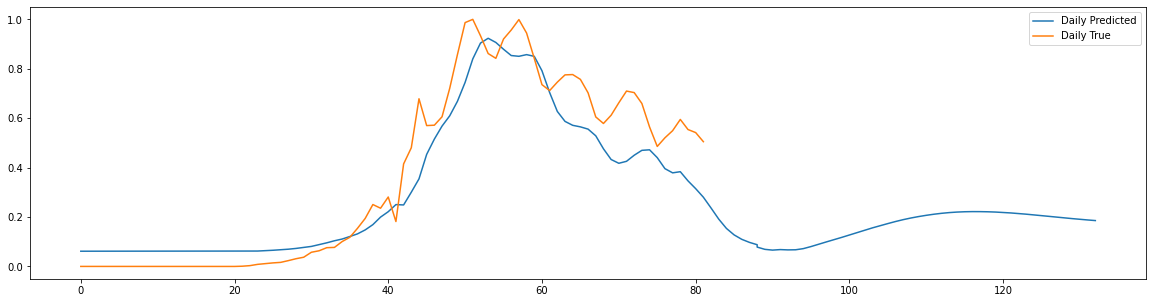

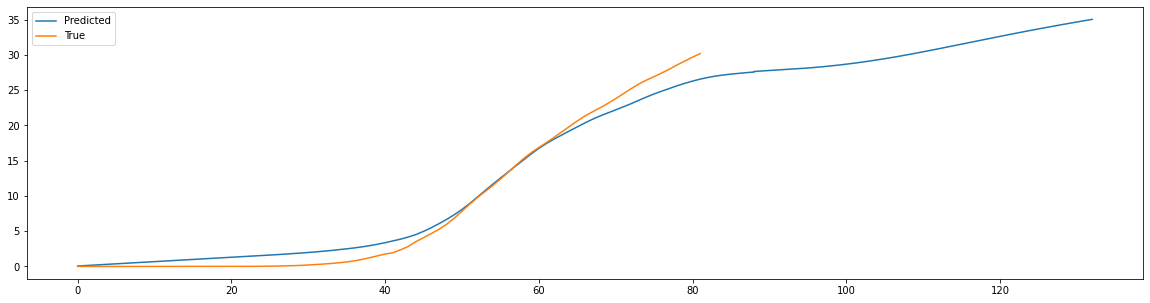

In [ ]:
eval_regions = ['Italy']
forecast_start_day = 79
# average_size = 3
pad_start = sequence_length
pad_end = 45

eval_data, _ = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = evaluate(models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=eval_data.index[sequence_length:])
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=eval_data.index[sequence_length:])


pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats.mean())

#### Brazil

MAPE    7116.755747
XCOR       0.953949
dtype: float64


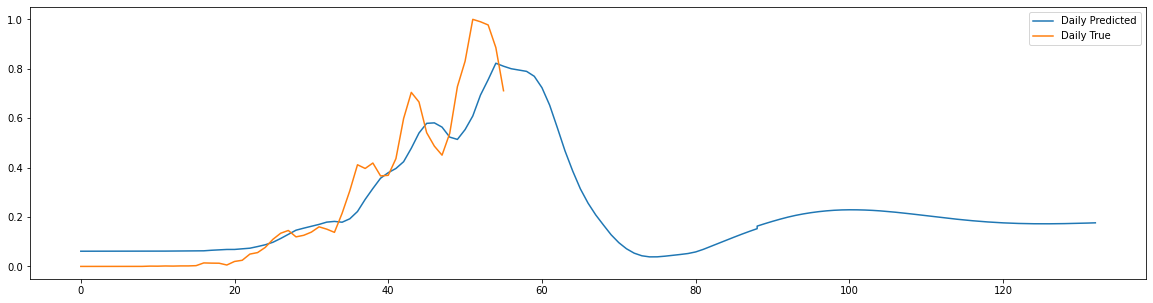

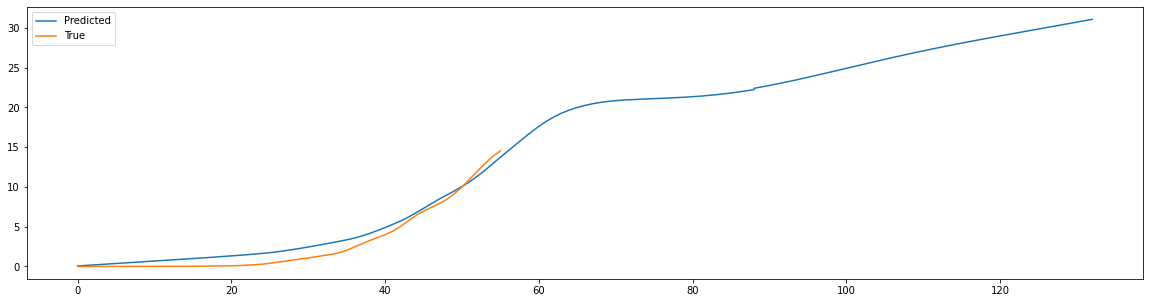

In [ ]:
eval_regions = ['Brazil']
forecast_start_day = 55
# average_size = 3
pad_start = sequence_length
pad_end = 45

eval_data, _ = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = evaluate(models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=eval_data.index[sequence_length:])
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=eval_data.index[sequence_length:])

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats.mean())

### Italy - Mimmo Data

In [ ]:
forecast_start_day = 56
average_size = 3
pad_start = sequence_length
pad_end = 45

#### Data Preprocessing

(56, 21)


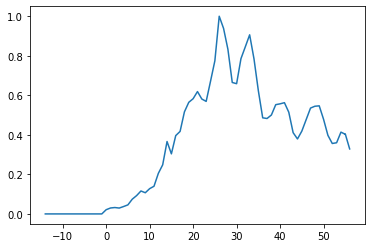

In [ ]:
ddf = pd.read_json('dpc-covid19-ita-regioni.json')
posdf = ddf[['denominazione_regione', 'lat', 'long']].drop_duplicates()
regions = ddf.denominazione_regione.unique()
ddf.data = pd.to_datetime(ddf.data)
ddf.set_index(ddf.data)
dates = ddf.data.unique()


mdf = pd.DataFrame(index=np.arange(len(dates)), columns=regions)
for region in regions:
    mdf[region] = ddf[ddf.denominazione_regione == region]['nuovi_positivi'].cumsum().values

print(mdf.shape)
eval_data, _ = get_data(mdf, regions=None, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
eval_data['Lombardia'].plot()

#### Forecasting

In [ ]:
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = evaluate(models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=eval_data.index[sequence_length:])
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=eval_data.index[sequence_length:])

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

                             MAPE      XCOR
Abruzzo                196.878066  0.867830
Basilicata              75.144744  0.888156
P.A. Bolzano           160.155075  0.881217
Calabria               150.448576  0.789228
Campania                76.441963  0.918702
Emilia-Romagna          48.488043  0.943293
Friuli Venezia Giulia   38.651367  0.870625
Lazio                  183.604068  0.959688
Liguria                 46.842979  0.902462
Lombardia               30.854733  0.922749
Marche                 133.785146  0.945397
Molise                 131.102440  0.700549
Piemonte               270.373128  0.948995
Puglia                 181.430571  0.916989
Sardegna                82.533158  0.824143
Sicilia                206.906177  0.891025
Toscana                238.698968  0.935353
P.A. Trento             66.320887  0.852883
Umbria                  82.834052  0.926082
Valle d'Aosta           66.538807  0.656739
Veneto                  31.894976  0.925321
MAPE    119.044187
XCOR      0.8

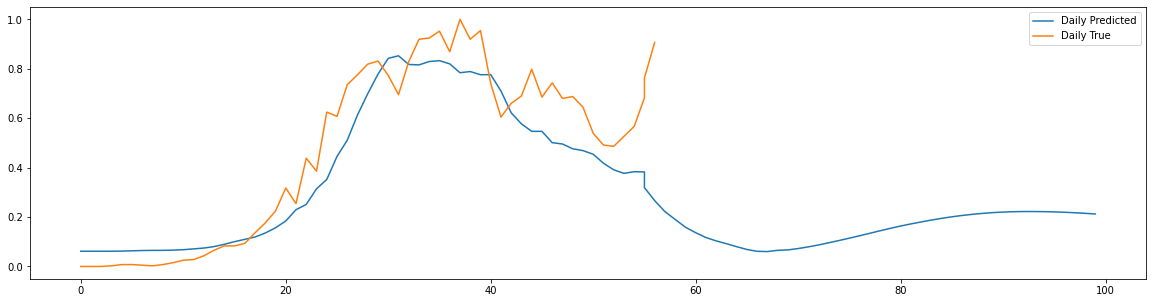

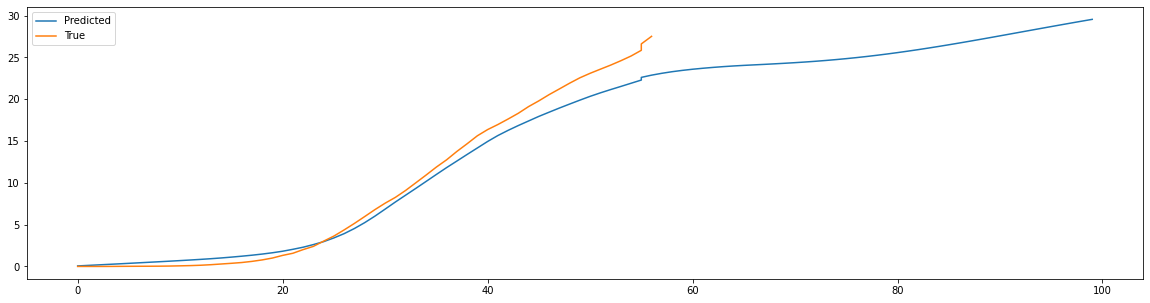

In [ ]:
region = 'Puglia'
pd.DataFrame(np.stack([predicted_df[region].values, trues_df[region].values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df[region].cumsum().values, trues_df[region].cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

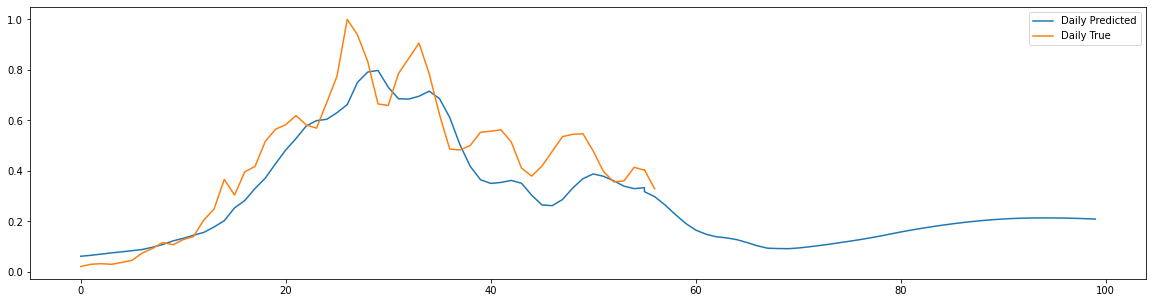

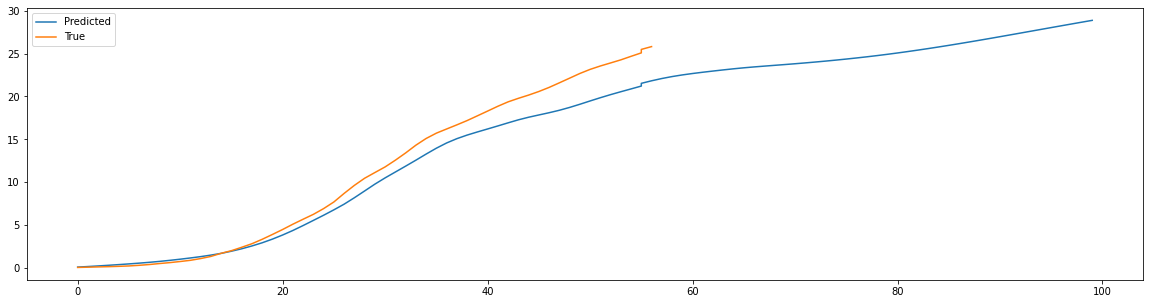

In [ ]:
region = 'Lombardia'
pd.DataFrame(np.stack([predicted_df[region].values, trues_df[region].values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df[region].cumsum().values, trues_df[region].cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

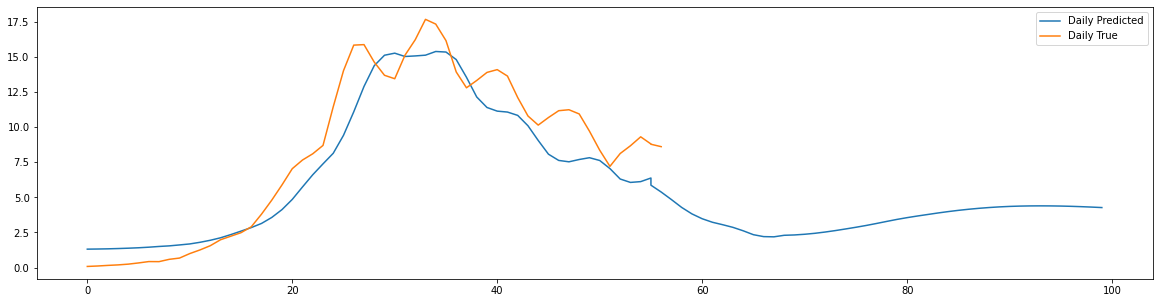

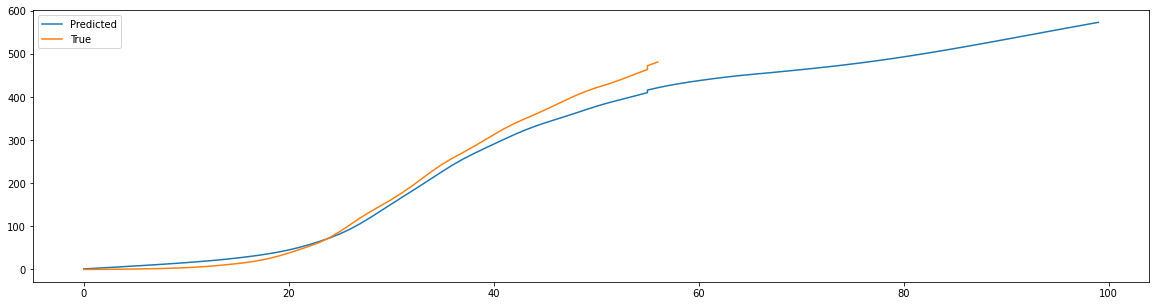

In [ ]:
# Summed of all Italy Cities
pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

#### Save Data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# workspace = '/content/drive/My Drive/Colab Notebooks/COVID19'
# df_folder = workspace + '/MimmoData/train-china_z4_avg3_clustering/'
# predicted_df.to_csv(df_folder + 'predictions.csv')
# trues_df.to_csv(df_folder + 'trues.csv')

# for i, model in enumerate(mae_models):
#     model.save_weights(df_folder + 'models/model%d.h5' % i)

# Generate Report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

workspace = '/content/drive/My\ Drive/Colab\ Notebooks/COVID19/'
nb_name = 'COVID19\ Time\ Series\ -\ LSTMs'
!cp {workspace + nb_name} .
!jupyter nbconvert  {nb_name}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook COVID19 Time Series - LSTMs to html
[NbConvertApp] Writing 1148531 bytes to COVID19 Time Series - LSTM.html
